In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [3]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170500096/170498071 [==============================] - 11s 0us/step


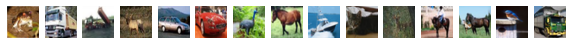

In [4]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 15, figsize=(10, 1))
for i in range(15):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [5]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [6]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        tf.keras.layers.BatchNormalization(),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        tf.keras.layers.BatchNormalization(),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_3'),
        MaxPooling2D(pool_size=(4, 4), name='pool_2'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        tf.keras.layers.Dropout(0.5),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [ ]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 16)        64        
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 8)           32        
_________________________________________________________________
conv_3 (Conv2D)              (None, 5, 5, 8)           584       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 1, 1, 8)           0

In [ ]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.107


#### Train model with checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

***Saving Weights only***

In [ ]:
# Create Tensorflow checkpoint object
path ='model_checkpoints/checkpoints'                #At the end of every epoch it will overwrite the same file and will save weights.
checkpoint = ModelCheckpoint(filepath=path, frequency='epoch', save_weights_only=True, verbose=1 )


In [ ]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x_train,y_train,epochs=3, batch_size=64, callbacks=[checkpoint])


Epoch 1/3
157/157 [==============================] - 11s 67ms/step - loss: 2.3051 - accuracy: 0.1429

Epoch 00001: saving model to model_checkpoints/checkpoints
Epoch 2/3
157/157 [==============================] - 10s 66ms/step - loss: 2.1182 - accuracy: 0.2034

Epoch 00002: saving model to model_checkpoints/checkpoints
Epoch 3/3
157/157 [==============================] - 10s 66ms/step - loss: 1.9979 - accuracy: 0.2360

Epoch 00003: saving model to model_checkpoints/checkpoints


In [ ]:
! ls -1h  model_checkpoints

checkpoint
checkpoints.data-00000-of-00001
checkpoints.index


In [ ]:
# Have a look at what the checkpoint creates

!dir model_checkpoints

checkpoint  checkpoints.data-00000-of-00001  checkpoints.index


In [ ]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test,y_test)

accuracy: 0.215


#### Create new model, load weights

In [ ]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model2 = get_new_model()
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.102


In [ ]:
# Load weights -- accuracy is the same as the trained model
model2.load_weights(path)


In [ ]:
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.215


#### Clear directory

In [ ]:

! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

 
The keyword argument **save_best_only** defaults to false. But if you set it to be true, as I've done here, then the model will only save the weights according to a performance measure criteria. That criterion is set by their monitor keyword argument. The default value of this argument is val_loss, which I've shown here. In this case, the callback only saves the weights if the validation loss is the best value seen so far in the training run.

filename itself can be formatted with whatever keys are available in the logs dictionary. So for example, if we're saving the model every 1,000 samples, we could make the filename include the **epoch **and **batch number**. **If we do this, then no saved files would be overwritten as they would all get a unique filename.**


**save_freq:** 

'epoch' or integer. When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches. If the Model is compiled with steps_per_execution=N, then the saving criteria will be checked every Nth batch. Note that if the saving isn't aligned to epochs, the monitored metric may potentially be less reliable (it could reflect as little as 1 batch, since the metrics get reset every epoch). Defaults to 'epoch'.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
x_train.shape

(10000, 32, 32, 3)

In [ ]:
# Create Tensorflow checkpoint object with epoch and batch details
# Creating a model which saves weights every 5000 batch.

checkpoint_5000_path = 'checkpoint_5000_/checkpoint_{epoch:02d}_{loss:.2f}'

model = get_new_model()
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path, verbose=True, save_weights_only=True,
                                  save_freq=5000)
model.fit(x_train, y_train, batch_size=1, validation_data=(x_test,y_test), epochs=3, verbose= True, callbacks=[checkpoint_5000])

#Total 10000batches are there with size 1.

Epoch 1/3
 4999/10000 [=============>................] - ETA: 17s - loss: 2.3252 - accuracy: 0.1344
Epoch 00001: saving model to checkpoint_5000_/checkpoint_01_2.25
 9992/10000 [============================>.] - ETA: 0s - loss: 2.2713 - accuracy: 0.1509
Epoch 00001: saving model to checkpoint_5000_/checkpoint_01_2.18
10000/10000 [==============================] - 38s 4ms/step - loss: 2.2712 - accuracy: 0.1509 - val_loss: 2.2479 - val_accuracy: 0.1650
Epoch 2/3
 4994/10000 [=============>................] - ETA: 28s - loss: 2.0754 - accuracy: 0.2043
Epoch 00002: saving model to checkpoint_5000_/checkpoint_02_2.06
 9998/10000 [============================>.] - ETA: 0s - loss: 2.0576 - accuracy: 0.2156
Epoch 00002: saving model to checkpoint_5000_/checkpoint_02_2.02
10000/10000 [==============================] - 59s 6ms/step - loss: 2.0576 - accuracy: 0.2156 - val_loss: 2.3799 - val_accuracy: 0.1500
Epoch 3/3
 4993/10000 [=============>................] - ETA: 28s - loss: 1.9462 - accurac

**In this case it will not save any weight because the no of batches are 500 and you wanted it to save after every 5000 batch**.

In [ ]:
# Create Tensorflow checkpoint object with epoch and batch details
# Creating a model which saves weights every 5000 batch

checkpoint_5000_path = 'checkpoint_5000__/checkpoint_{epoch:02d}_{loss:.2f}'

model = get_new_model()
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path, verbose=True, save_weights_only=True,
                                  save_freq=5000)
model.fit(x_train, y_train, batch_size=10, validation_data=(x_test,y_test), epochs=3, verbose= True, callbacks=[checkpoint_5000])

Epoch 1/3
1000/1000 [==============================] - 19s 18ms/step - loss: 2.2869 - accuracy: 0.1698 - val_loss: 1.9669 - val_accuracy: 0.2800
Epoch 2/3
1000/1000 [==============================] - 17s 17ms/step - loss: 1.9802 - accuracy: 0.2467 - val_loss: 1.8220 - val_accuracy: 0.3430
Epoch 3/3
1000/1000 [==============================] - 17s 17ms/step - loss: 1.8794 - accuracy: 0.2898 - val_loss: 1.7368 - val_accuracy: 0.3530


In [ ]:
# Create Tensorflow checkpoint object with epoch and batch details
# Creating a model which saves weights every 500 batch

checkpoint_500_path = 'checkpoint_500__/checkpoint_{epoch:02d}_{loss:.2f}'

model = get_new_model()
checkpoint_500 = ModelCheckpoint(filepath=checkpoint_500_path, verbose=True, save_weights_only=True,
                                  save_freq=500)
model.fit(x_train, y_train, batch_size=10, validation_data=(x_test,y_test), epochs=3, verbose= True, callbacks=[checkpoint_500])

#in this case total batches is 500 with batch size 10.

Epoch 1/3
 498/1000 [=============>................] - ETA: 7s - loss: 2.4361 - accuracy: 0.1299
Epoch 00001: saving model to checkpoint_500__/checkpoint_01_2.29
1000/1000 [==============================] - ETA: 0s - loss: 2.3309 - accuracy: 0.1491
Epoch 00001: saving model to checkpoint_500__/checkpoint_01_2.18
1000/1000 [==============================] - 16s 15ms/step - loss: 2.3308 - accuracy: 0.1491 - val_loss: 2.1378 - val_accuracy: 0.2130
Epoch 2/3
 499/1000 [=============>................] - ETA: 7s - loss: 2.0040 - accuracy: 0.2331
Epoch 00002: saving model to checkpoint_500__/checkpoint_02_1.99
 998/1000 [============================>.] - ETA: 0s - loss: 1.9899 - accuracy: 0.2371
Epoch 00002: saving model to checkpoint_500__/checkpoint_02_1.96
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9898 - accuracy: 0.2371 - val_loss: 1.8418 - val_accuracy: 0.2990
Epoch 3/3
 500/1000 [==============>...............] - ETA: 7s - loss: 1.9002 - accuracy: 0.2654
Epoch

In [ ]:
# Have a look at what the checkpoint creates
! ls -1h checkpoint_500__



checkpoint
checkpoint_01_2.18.data-00000-of-00001
checkpoint_01_2.18.index
checkpoint_01_2.29.data-00000-of-00001
checkpoint_01_2.29.index
checkpoint_02_1.96.data-00000-of-00001
checkpoint_02_1.96.index
checkpoint_02_1.99.data-00000-of-00001
checkpoint_02_1.99.index
checkpoint_03_1.88.data-00000-of-00001
checkpoint_03_1.88.index
checkpoint_03_1.90.data-00000-of-00001
checkpoint_03_1.90.index


#### Work with model saving criteria

In [ ]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [ ]:
# Create a new instance of untrained model

model=get_new_model()

In [ ]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_checkpoint_best/checkpoint"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,save_weights_only=True,save_freq='epoch',monitor='val_accuracy',
                                save_best_only="True",verbose=1)


In [ ]:
# Fit the model and save only the weights with the highest validation accuracy
history=model.fit(x_train,y_train,
                  epochs=50,
                  validation_data=(x_test,y_test),
                  batch_size=10,
                  callbacks=[checkpoint_best],
                  verbose=1)


Epoch 1/50
10/10 [==============================] - 1s 45ms/step - loss: 2.9043 - accuracy: 0.0960 - val_loss: 2.3017 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to model_checkpoint_best/checkpoint
Epoch 2/50
10/10 [==============================] - 0s 23ms/step - loss: 2.5213 - accuracy: 0.1164 - val_loss: 2.3038 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/50
10/10 [==============================] - 0s 23ms/step - loss: 2.5105 - accuracy: 0.0299 - val_loss: 2.3080 - val_accuracy: 0.0900

Epoch 00003: val_accuracy did not improve from 0.10000
Epoch 4/50
10/10 [==============================] - 0s 27ms/step - loss: 2.4278 - accuracy: 0.0946 - val_loss: 2.3068 - val_accuracy: 0.0900

Epoch 00004: val_accuracy did not improve from 0.10000
Epoch 5/50
10/10 [==============================] - 0s 23ms/step - loss: 2.4463 - accuracy: 0.0554 - val_loss: 2.3019 - val_accuracy: 0.1100

Epoch 00005: val_ac

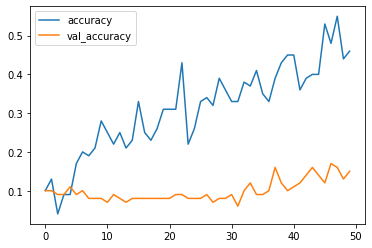

In [ ]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [ ]:
# Inspect the checkpoint directory

!ls -1h model_checkpoint_best

checkpoint
checkpoint.data-00000-of-00001
checkpoint.index


In [ ]:
# Create a new model with the saved weights

new_model=get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model,x_test,y_test)

accuracy: 0.170


#### Clear directory

In [ ]:
! rm -r checkpoint_5000 checkpoint_5000_ checkpoint_5000__ checkpoint_500__ checkpoint_5000 model_checkpoint_best

rm: cannot remove 'checkpoint_5000': No such file or directory
rm: cannot remove 'checkpoint_5000_': No such file or directory
rm: cannot remove 'checkpoint_5000__': No such file or directory
rm: cannot remove 'checkpoint_500__': No such file or directory


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath = checkpoint_path, save_weights_only=False,
save_freq = 'epoch',
verbose=1
)


In [25]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x_train, y_train, epochs=5, callbacks = [checkpoint])

Epoch 1/5
313/313 [==============================] - 12s 36ms/step - loss: 2.3168 - accuracy: 0.1405

Epoch 00001: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
Epoch 2/5
313/313 [==============================] - 11s 36ms/step - loss: 2.0538 - accuracy: 0.2102

Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
Epoch 3/5
313/313 [==============================] - 11s 36ms/step - loss: 1.9223 - accuracy: 0.2630

Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
Epoch 4/5
313/313 [==============================] - 11s 36ms/step - loss: 1.8791 - accuracy: 0.2694

Epoch 00004: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
Epoch 5/5
313/313 [==============================] - 11s 36ms/step - loss: 1.8163 - accuracy: 0.3178

Epoch 00005: saving model to model_checkpoints
INFO:tensorflow

**assets**- Files are stored which is used by tensorflowgraph.(now it is empty)

**saved_model.pb**- Stores the tensorflow graph(Model architecture).contain all the information when we built and compiled the model including optimizer state.

**variables**- weights

#### Inspect what the checkpoint has created

In [27]:
# Have a look at what the checkpoint creates
!dir model_checkpoints


assets	saved_model.pb	variables


In [19]:
!dir model_checkpoints \ assets

dir: cannot access ' assets': No such file or directory
model_checkpoints:
assets	saved_model.pb	variables


In [16]:
# Enter variables directory
!dir model_checkpoints\variables


dir: cannot access 'model_checkpointsvariables': No such file or directory


In [12]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.339


#### Create new model from scratch

In [30]:
# Delete model
del model


In [31]:
from tensorflow.keras.models import load_model

**Load_model**- will return all the weights ,complete modelarchitecture and instance we could now resume training by callinfg fit()

In [32]:
# Reload model from scratch
newModel = load_model(checkpoint_path)
get_test_accuracy(newModel, x_test, y_test)


accuracy: 0.338


#### Use the .h5 format to save model

In [33]:
# Save the model in .h5 format
newModel.save('myModel.h5')


In [34]:
# Inspect .h5 file
!dir myModel.h5


myModel.h5


In [35]:
# Delete model
del newModel


In [36]:
# Reload model from scratch
newModel = load_model('myModel.h5')
get_test_accuracy(newModel, x_test, y_test)

accuracy: 0.338


#### Clear directory

In [37]:
! rm -r model_checkpoints
! rm my_model.h5

rm: cannot remove 'my_model.h5': No such file or directory


***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50 

In [39]:
# Build Keras ResNet50 model
model = ResNet50(weights='imagenet')


102973440/102967424 [==============================] - 1s 0us/step


In [47]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Import and preprocess 3 sample images

In [40]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

cat1 = load_img('data/cat1.jpg', target_size=(224, 224))
bird1 = load_img('data/bird1.jpg', target_size=(224, 224))
bird2 = load_img('data/bird2.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [41]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]             
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: bird

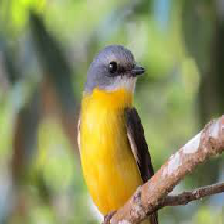

In [51]:
# Display image
bird1

In [52]:
# Display top 5 predictions

get_top_5_predictions(bird1)

,prediction,probability
1,jacamar,0.555936
2,toucan,0.229539
3,bee_eater,0.0656247
4,guenon,0.0271744
5,goldfinch,0.0245254


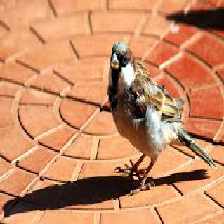

In [53]:
# Display image
bird2


In [54]:
# Display top 5 predictions

get_top_5_predictions(bird2)

,prediction,probability
1,coucal,0.238121
2,brambling,0.132173
3,bee_eater,0.108545
4,bulbul,0.0544892
5,jacamar,0.0530968


##### Image 3: cat

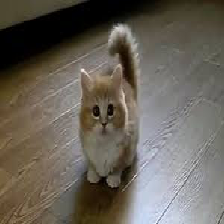

In [55]:
# Display image
cat1


In [56]:
# Display top 5 predictions

get_top_5_predictions(cat1)

,prediction,probability
1,Samoyed,0.730191
2,Pomeranian,0.151052
3,Eskimo_dog,0.021735
4,Siberian_husky,0.0162419
5,Shetland_sheepdog,0.015954


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [59]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [70]:
# Build Google's Mobilenet v1 model
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.summary()                  # Here we have a module which act as a layer  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [61]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

bird1 = load_img("data/bird1.jpg", target_size=(160, 160))
bird2 = load_img("data/bird2.jpg", target_size=(160, 160))
cat1 = load_img("data/cat1.jpg", target_size=(160, 160))

In [62]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [63]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: bird1

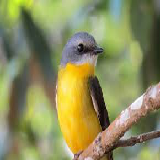

In [64]:
bird1

In [65]:
get_top_5_predictions(bird1)

,prediction
1,jacamar
2,goldfinch
3,coucal
4,robin
5,bee eater


##### Image 2: bird2

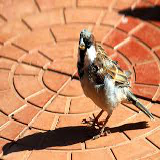

In [66]:
bird2

In [67]:
get_top_5_predictions(bird2)

,prediction
1,bulbul
2,reel
3,ground beetle
4,disk brake
5,long-horned beetle


##### Image 3: cat

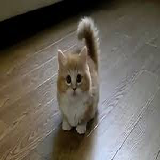

In [68]:
cat1

In [69]:


get_top_5_predictions(cat1)

,prediction
1,Siberian husky
2,malamute
3,dingo
4,Eskimo dog
5,Samoyed
